# Application : Car Dection with OpenCV 

In [4]:
import cv2

# Load the pre-trained Haar Cascade classifier for car detection
car_cascade = cv2.CascadeClassifier('cars.xml')

# Load the video
video_path = 'cars.mp4'
cap = cv2.VideoCapture(video_path)

while cap.isOpened():
    # Read a frame from the video
    ret, frame = cap.read()
    
    if not ret:
        break

    # Convert the frame to grayscale (required for Haar Cascade detection)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Perform car detection
    cars = car_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Draw rectangles around the detected cars
    for (x, y, w, h) in cars:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the result
    cv2.imshow('Car Detection', frame)

    # Exit the loop when 'q' key is pressed
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


 Architecture diagram of YOLOv8
 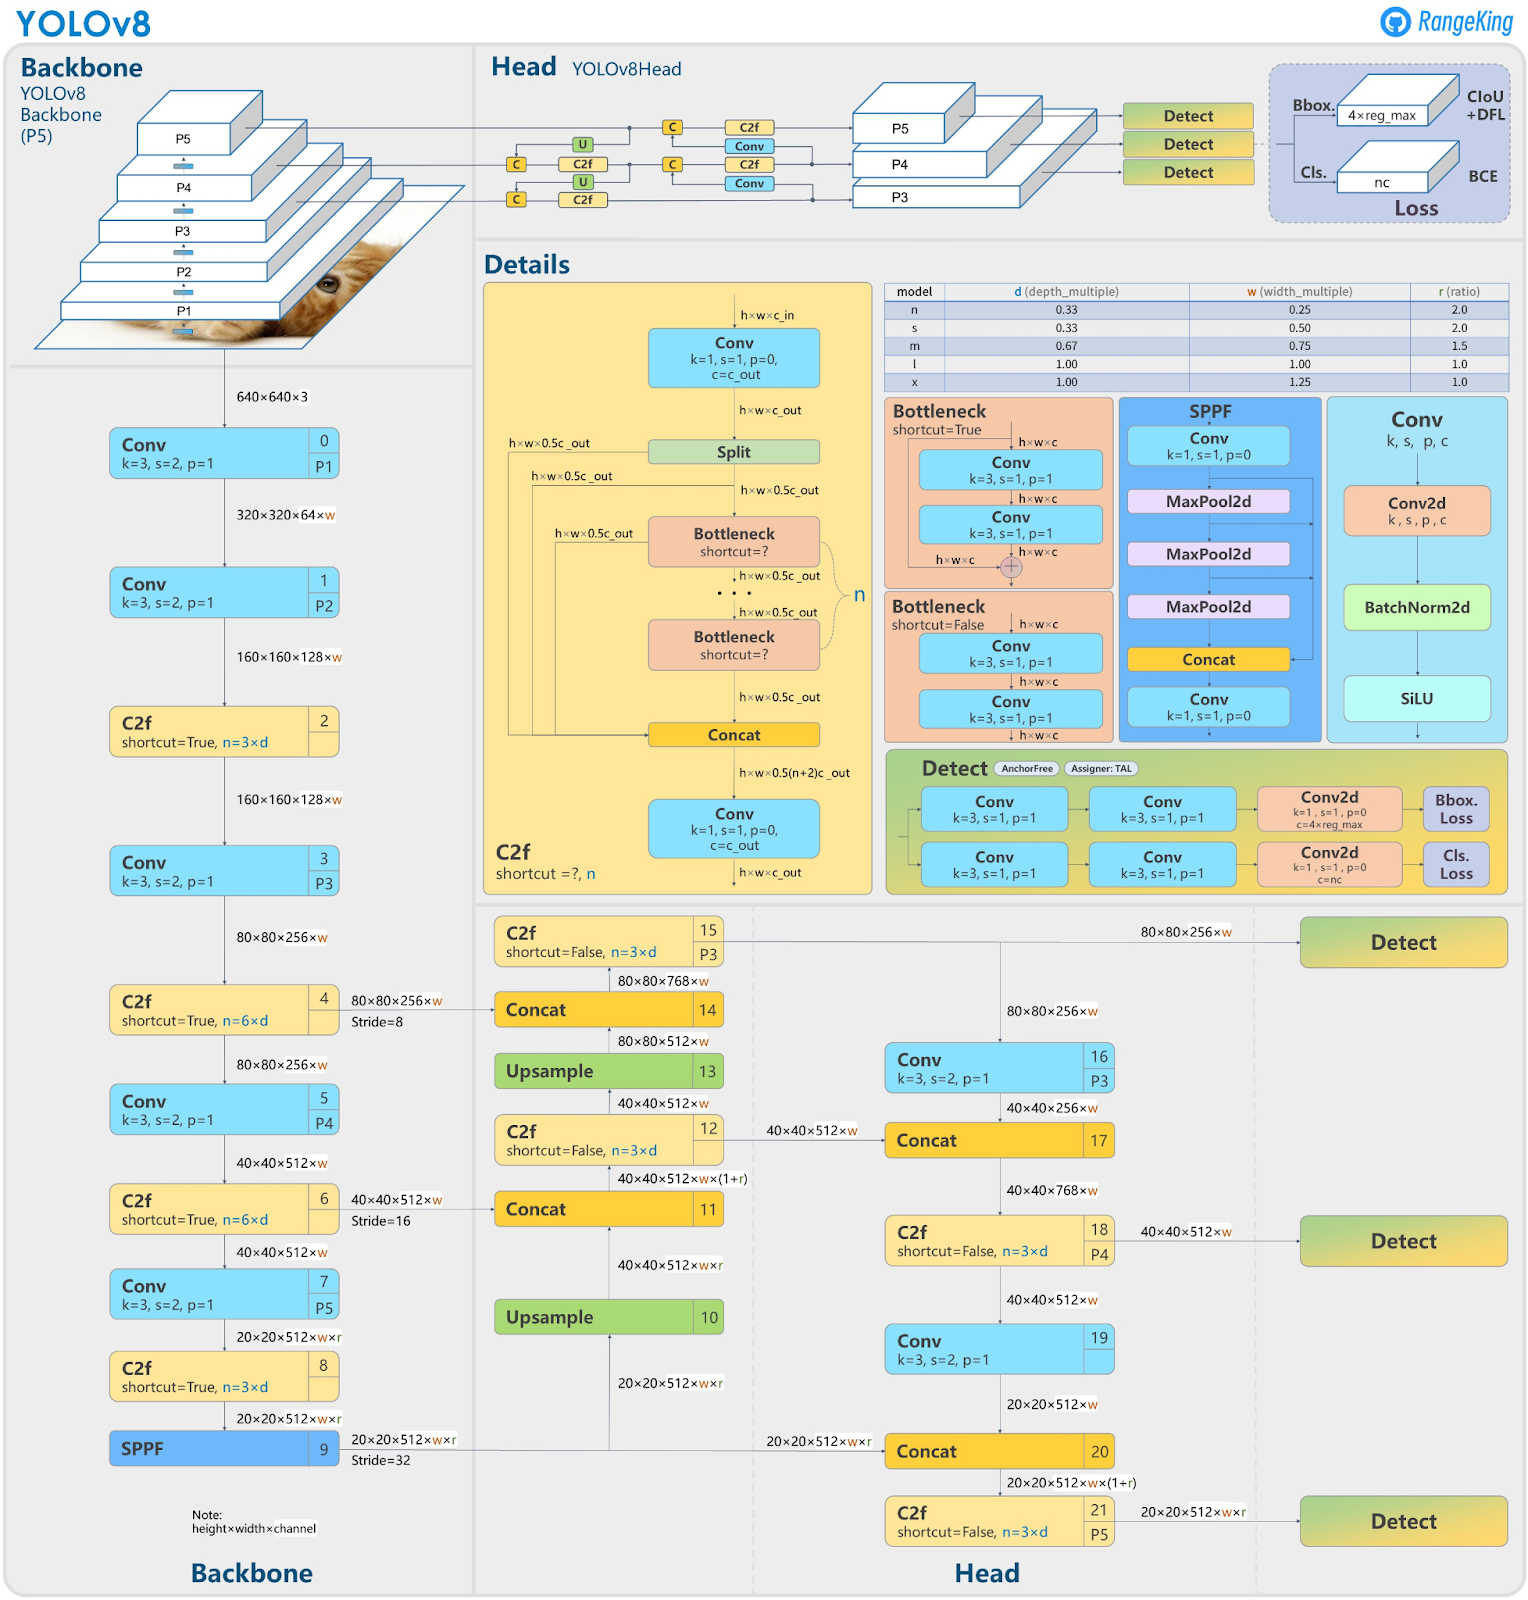

# Car Dection with Yolo8

In [14]:
import cv2
import logging
from ultralytics import YOLO
logging.getLogger('ultralytics').setLevel(logging.WARNING)
model = YOLO('yolov8n.pt')

video_path = "cars.mp4"
# video_path = "USE/alpaca-short.mp4"
cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
output_path = "output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Choose the appropriate codec for your system (e.g., 'XVID' for AVI)
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Loop through the video frames
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        results = model(frame)
        
        # Annotate the frame
        annotated_frame = results[0].plot()

        # Write the annotated frame to the output video
        out.write(annotated_frame)

        # Display the annotated frame
        cv2.imshow("YOLOv8 Inference", annotated_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
out.release()
cv2.destroyAllWindows()

In [6]:
#pip install tqdm

# Detect All Object

In [7]:
import cv2
# Load the YOLOv8 model
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

# Path to the input image
image_path = "bus.jpg"
image = cv2.imread(image_path)

# Run YOLOv8 inference on the image
results = model.predict(image)

# Annotate the image with detection results
annotated_image = results[0].plot()

# Display the annotated image
cv2.imshow("YOLOv8 Inference", annotated_image)
cv2.waitKey(0)  # Wait for a key press to close the window
cv2.destroyAllWindows()

# Save the annotated image to a file
output_image_path = "annotated_image.jpg"
cv2.imwrite(output_image_path, annotated_image)


True

# Detect Object  score > 0.5 , Detect only person

In [12]:
import cv2
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

#from ultralytics import RTDETR
#model = RTDETR('rtdetr-l.pt')

# Path to the input image
image_path = "bus.jpg"
image = cv2.imread(image_path)

# Run YOLOv8 inference on the image
results = model.predict(image)
#print(results[0])
# Get boxes, scores, and classes from results
boxes = results[0].boxes.xyxy  # Bounding boxes
scores = results[0].boxes.conf  # Confidence scores
classes = results[0].boxes.cls  # Class IDs

# Filter detections with confidence greater than 0.5
filtered_boxes = []
filtered_scores = []
filtered_classes = []
for box, score, cls in zip(boxes, scores, classes):
    #if score > 0.5:
    if cls == 0 and score > 0.5:    
        filtered_boxes.append(box)
        filtered_scores.append(score)
        filtered_classes.append(cls)

# Annotate the image with filtered detection results
annotated_image = image.copy()
for box, score, cls in zip(filtered_boxes, filtered_scores, filtered_classes):
    x1, y1, x2, y2 = map(int, box)  # Convert box coordinates to integers
    label = f"{results[0].names[int(cls)]}: {score:.2f}"
    color = (0, 255, 0)  # Green color for the bounding box
    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(annotated_image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Display the annotated image
cv2.imshow("YOLOv8 Inference", annotated_image)
cv2.waitKey(0)  # Wait for a key press to close the window
cv2.destroyAllWindows()

# Save the annotated image to a file
output_image_path = "annotated_image.jpg"
cv2.imwrite(output_image_path, annotated_image)


True

In [1]:
#pip install supervision

# Real world Application: Yolo8 with openCV :estimate-speed-car

In [15]:
from collections import defaultdict, deque
import logging
import cv2
import numpy as np
from ultralytics import YOLO
logging.getLogger('ultralytics').setLevel(logging.WARNING)

import supervision as sv

SOURCE = np.array([[1252, 787], [2298, 803], [5039, 2159], [-550, 2159]])

TARGET_WIDTH = 25
TARGET_HEIGHT = 250

TARGET = np.array(
    [
        [0, 0],
        [TARGET_WIDTH - 1, 0],
        [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
        [0, TARGET_HEIGHT - 1],
    ]
)


class ViewTransformer:
    def __init__(self, source: np.ndarray, target: np.ndarray) -> None:
        source = source.astype(np.float32)
        target = target.astype(np.float32)
        self.m = cv2.getPerspectiveTransform(source, target)

    def transform_points(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points

        reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
        transformed_points = cv2.perspectiveTransform(reshaped_points, self.m)
        return transformed_points.reshape(-1, 2)



if __name__ == "__main__":
    source_video_path='vehicles.mp4'
    confidence_threshold=0.5
    target_video_path='output.mp4'
    iou_threshold=0.7
    video_info = sv.VideoInfo.from_video_path(video_path=source_video_path)
    model = YOLO("yolov8n.pt")

    byte_track = sv.ByteTrack(
        frame_rate=video_info.fps, track_thresh=confidence_threshold
    )

    thickness = sv.calculate_optimal_line_thickness(
        resolution_wh=video_info.resolution_wh
    )
    text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
    bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_scale=text_scale,
        text_thickness=thickness,
        text_position=sv.Position.BOTTOM_CENTER,
    )
    trace_annotator = sv.TraceAnnotator(
        thickness=thickness,
        trace_length=video_info.fps * 2,
        position=sv.Position.BOTTOM_CENTER,
    )

    frame_generator = sv.get_video_frames_generator(source_path=source_video_path)

    polygon_zone = sv.PolygonZone(polygon=SOURCE)
    view_transformer = ViewTransformer(source=SOURCE, target=TARGET)

    coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

    with sv.VideoSink(target_video_path, video_info) as sink:
        for frame in frame_generator:
            result = model(frame)[0]
            detections = sv.Detections.from_ultralytics(result)
            detections = detections[detections.confidence > confidence_threshold]
            detections = detections[polygon_zone.trigger(detections)]
            detections = detections.with_nms(threshold=iou_threshold)
            detections = byte_track.update_with_detections(detections=detections)

            points = detections.get_anchors_coordinates(
                anchor=sv.Position.BOTTOM_CENTER
            )
            points = view_transformer.transform_points(points=points).astype(int)

            for tracker_id, [_, y] in zip(detections.tracker_id, points):
                coordinates[tracker_id].append(y)

            labels = []
            for tracker_id in detections.tracker_id:
                if len(coordinates[tracker_id]) < video_info.fps / 2:
                    labels.append(f"#{tracker_id}")
                else:
                    coordinate_start = coordinates[tracker_id][-1]
                    coordinate_end = coordinates[tracker_id][0]
                    distance = abs(coordinate_start - coordinate_end)
                    time = len(coordinates[tracker_id]) / video_info.fps
                    speed = distance / time * 3.6
                    labels.append(f"#{tracker_id} {int(speed)} km/h")

            annotated_frame = frame.copy()
            annotated_frame = trace_annotator.annotate(
                scene=annotated_frame, detections=detections
            )
            annotated_frame = bounding_box_annotator.annotate(
                scene=annotated_frame, detections=detections
            )
            annotated_frame = label_annotator.annotate(
                scene=annotated_frame, detections=detections, labels=labels
            )

            sink.write_frame(annotated_frame)
            # Resize frame for displaying
            display_frame = cv2.resize(annotated_frame, (1200, 700))
            # Show frame
            cv2.imshow("frame", display_frame)
            #cv2.imshow("frame", annotated_frame)
            if cv2.waitKey(1) & 0xFF == ord("q"):
                break
        cv2.destroyAllWindows()
#estimate-speed-computer-vision #https://www.youtube.com/watch?v=uWP6UjDeZvY, https://blog.roboflow.com/estimate-speed-computer-vision/

SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.


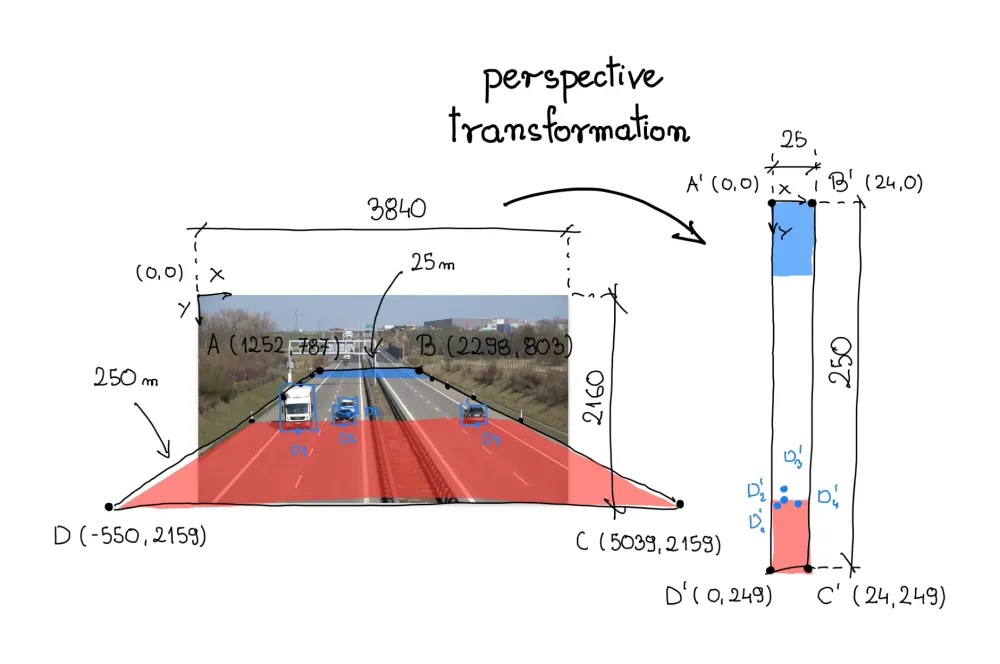